This is just random code for myself I store here

In [3]:
from qiskit import IBMQ
from qiskit.tools.monitor import backend_monitor, backend_overview
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit import BasicAer
from qiskit.tools.visualization import plot_state_city
from qiskit.tools.visualization import plot_histogram
#from qiskit_aqua.utils import *
import random as r
%matplotlib inline

In [4]:
#Hardware Overview (to do one time)

IBMQ.load_accounts()

In [5]:
backend_overview()
IBMQ.backends()
for backend in IBMQ.backends():
    print(backend.status())
    

ibmq_16_melbourne            ibmqx2                      ibmqx4
-----------------            ------                      ------
Num. Qubits:  14             Num. Qubits:  5             Num. Qubits:  5
Pending Jobs: 3              Pending Jobs: 0             Pending Jobs: 1
Least busy:   False          Least busy:   True          Least busy:   False
Operational:  True           Operational:  True          Operational:  True
Avg. T1:      59.5           Avg. T1:      59.6          Avg. T1:      44.5
Avg. T2:      74.6           Avg. T2:      45.8          Avg. T2:      22.8



BackendStatus(backend_name='ibmqx4', backend_version='1.0.0', operational=True, pending_jobs=1, status_msg='active')
BackendStatus(backend_name='ibmqx2', backend_version='1.0.0', operational=True, pending_jobs=0, status_msg='active')
BackendStatus(backend_name='ibmq_16_melbourne', backend_version='1.0.0', operational=True, pending_jobs=3, status_msg='calibrating')
BackendStatus(backend_name='ibmq_qasm_simulator', b

In [6]:
IBMQ.backends()[-1]

<IBMQSimulator('ibmq_qasm_simulator') from IBMQ()>

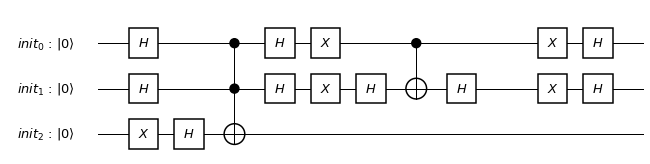

In [7]:
#Grover (with control bit)
init = QuantumRegister(3, 'init')
circinit = QuantumCircuit(init)

#Initialization
circinit.h(init[0])
circinit.h(init[1])
circinit.x(init[2])
circinit.h(init[2])

#Grover Operator
gro = QuantumRegister(3, 'gro')
circGO = QuantumCircuit(init)
#Oracle is just Toffoli so we search 11
circGO.ccx(init[0], init[1], init[2])
#Mean-Flip circuit
circGO.h(init[0])
circGO.h(init[1])
circGO.x(init[0])
circGO.x(init[1])
circGO.h(init[1])
circGO.cx(init[0],init[1])
circGO.h(init[1])
circGO.barrier(init)
circGO.x(init[0])
circGO.x(init[1])
circGO.h(init[0])
circGO.h(init[1])

#We can concatenate two circuits with the same registers
qc = circinit+circGO

#The grover operator with initialization
qc.draw(output='mpl', plot_barriers = False)


[ 0.   +0.j  0.   +0.j  0.   +0.j -0.707+0.j  0.   +0.j  0.   +0.j
  0.   +0.j  0.707+0.j]


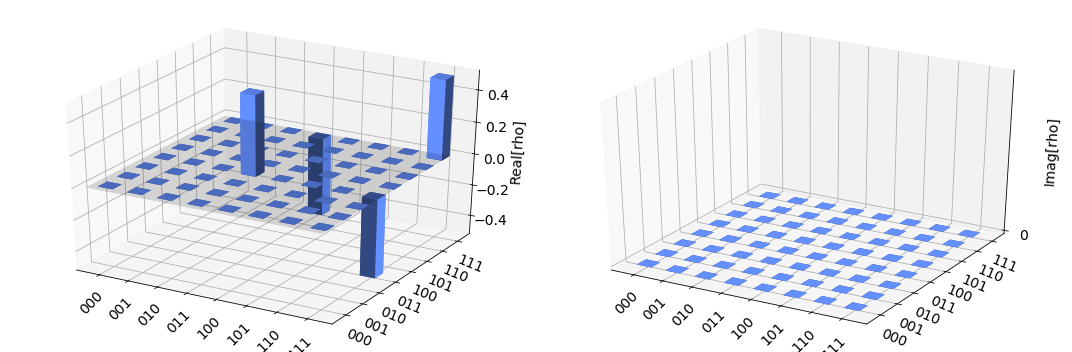

In [8]:
#We can choose our backend (here the simulator for the states)
backend = BasicAer.get_backend('statevector_simulator')
job = execute(qc, backend)

#The result here is the complete superposition, so we can plot it that way.
result = job.result()
outputstate = result.get_statevector(qc, decimals = 3)
print(outputstate)

plot_state_city(outputstate)

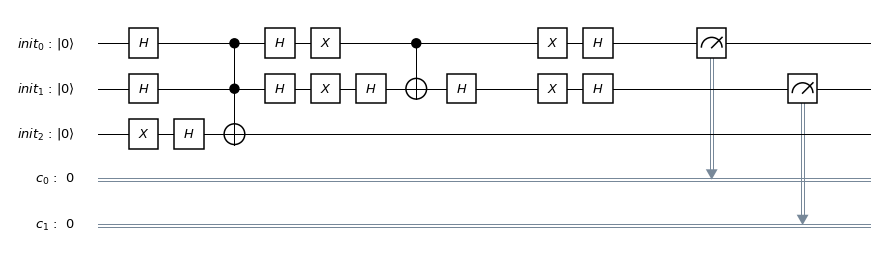

In [9]:
# We want to measure it so we create a classical register
c = ClassicalRegister(2, 'c')

# Create a Quantum Circuit
meas = QuantumCircuit(init, c)
meas.barrier(init)

# map the quantum measurement to the classical bits
meas.measure(init[0],c[0])
meas.measure(init[1],c[1])

# We add the measure part to the end of the circuit
qc_m = qc+meas

#drawing the circuit
qc_m.draw(output='mpl', plot_barriers = False)

{'11': 1024}


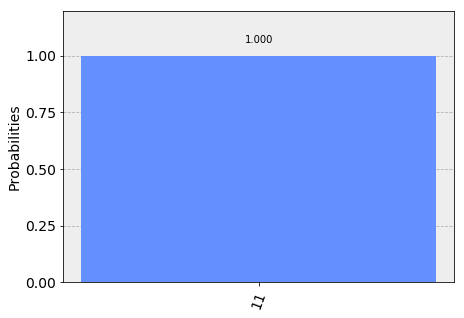

In [10]:
# We want to use the simulator for the measures
backend_sim = BasicAer.get_backend('qasm_simulator')

# Because it can be random, we can choose the number of shots we want to do
job_sim = execute(qc_m, backend_sim, shots=1024)

# Here the results are measures not states
result_sim = job_sim.result()

counts = result_sim.get_counts(qc_m)
print(counts)

plot_histogram(counts)

In [11]:
#To study the generalization of the algorithm, we can use matrix
#We have to be cautious though of not losing track of the real gates used

#Basic gates
H = np.array([[1,1],[1,-1]])*1/(np.sqrt(2))
X = np.array([[0,1],[1,0]])
S = np.diag([1,1j])
I1 = np.eye(2)
Cx = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
Cxinv = np.array([[1,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0]])

def grover(n):
    """Returns the matrix of the Grover Operator (no oracle, with each of the intermediate matrix,
    Hn is the n-bits Hadamar, Xn is the n-bits NOT, H_nm1 is the Hadamar on the last qbit and 
    Tn is the n-bit Control NOT."""
    H = np.array([[1,1],[1,-1]])*1/(np.sqrt(2))
    X = np.array([[0,1],[1,0]])
    I1 = np.eye(2)
    Tn = np.eye(2**n)
    temp = Tn[-2,].copy()
    Tn[-2,]= Tn[-1,].copy()
    Tn[-1,]= temp
    Hn = H
    Xn = X
    H_nm1 = H
    for _ in range(1,n):
        Hn = np.kron(Hn,H)
        Xn = np.kron(Xn,X)
        H_nm1 = np.kron(I1,H_nm1)
    return [Hn@Xn@H_nm1@Tn@H_nm1@Xn@Hn, Hn, Xn, H_nm1,Tn]


res = grover(4)


In [12]:
#To be able to build the n-bits controle not, 
#the only gate not present in qskit for grover,
#we need to study the SQRT of X (NOT)

a = 0.5*(1+1j)
b = 0.5*(1-1j)

#The root of X
RX = np.array([[a,b],[b,a]])

#Its transposed conjugate
RXd = np.matrix(RX).getH()

#Every Unitary matrix can be decomposed into a product
#of three matrix (a rotation around z, a rotation around y and
#a roation around z), with eventually a phase shift

def rz(alpha):
    return np.diag([np.exp(1j*alpha/2),np.exp(-1j*alpha/2)])

def ry(theta):
    return np.array([[np.cos(theta/2),np.sin(theta/2)],[-np.sin(theta/2),np.cos(theta/2)]])

def ph(delta):
    return np.diag([np.exp(1j*delta),np.exp(1j*delta)])

#Here we have the decomposition of RX
delta = np.pi/4

alpha = -np.pi/2

beta = np.pi/2

theta = np.pi/2

#RX = RX1@RX2@RX3@RX4
RX1 = np.diag([np.exp(1j*delta),np.exp(1j*delta)])
RX2 = np.diag([np.exp(1j*alpha/2),np.exp(-1j*alpha/2)])
RX3 = np.array([[np.cos(theta/2),np.sin(theta/2)],[-np.sin(theta/2),np.cos(theta/2)]])
RX4 = np.diag([np.exp(1j*beta/2),np.exp(-1j*beta/2)])

#The final goal is to control RX, which is possible with this, because
#RX = AXBXC, ans ABC=I, so with two CX we can control RX
A = rz(alpha)@ry(theta/2)
B = ry(-theta/2)@rz(-(alpha+beta)/2)
C = rz((beta-alpha)/2)

#And this is the general matrix for the n-th root of X
def rootX(n):
    return np.array([[np.cos(np.pi/(2*n)),-1j*np.sin(np.pi/(2*n))],[-1j*np.sin(np.pi/(2*n)),np.cos(np.pi/(2*n))]])


In [15]:
#Then we translate matrix into gates for Qiskit
def rootx(circuit, reg, target):
    """Adds a SQRT(X) gate to circ, on reg at qbit target"""
    circuit.barrier(reg)
    circuit.u1(np.pi/(4), target)
    circuit.x(target)
    circuit.u1(np.pi/(4), target)
    circuit.x(target)
    circuit.u3(np.pi/2,-np.pi/2,np.pi/2,target)
    return 1

def crootx(circuit, reg, control, target):
    """Adds a Control-SQRT(X) gate to circ, on reg controlled by control at qbit target"""
    circuit.barrier(reg)
    circuit.cu1(np.pi/(4), control, target)
    circuit.cx(control, target)
    circuit.cu1(np.pi/(4), control, target)
    circuit.cx(control, target)
    circuit.cu3(np.pi/2,-np.pi/2,np.pi/2,control, target)
    return 1

def crootnx(circuit, reg, control, target, n, d):
    """Adds a Control-n-th-root(X) gate to circuit, on reg, controlled by control at qbit target, dagger if d"""
    circuit.barrier(reg)
    if d:
        circuit.cu1(-np.pi/(2*n), control, target)
        circuit.cx(control, target)
        circuit.cu1(-np.pi/(2*n), control, target)
        circuit.cx(control, target)
        circuit.cu3(np.pi/n,np.pi/2,-np.pi/2, control, target)
    else:
        circuit.cu1(np.pi/(2*n), control, target)
        circuit.cx(control, target)
        circuit.cu1(np.pi/(2*n), control, target)
        circuit.cx(control, target)
        circuit.cu3(np.pi/n,-np.pi/2,np.pi/2, control, target)
    return 1

def cnrootnx(c, r, cont, target, n, d=False):
    """Adds a len(cont)-qbits-Control-n-th-root(X) gate to c, on r, controlled by the List cont at qbit target, dagger if d"""
    c.barrier(r)
    if len(cont)==1:
        crootnx(c, r, cont[0], target, n, d)
    else:
        cnrootnx(c, r, [cont[0]], target, 2*n, d)
        cnx(c, r, cont[1:],cont[0])#2?
        cnrootnx(c, r, [cont[0]], target, 2*n, not d)
        cnx(c, r, cont[1:],cont[0])#2?
        cnrootnx(c, r, cont[1:], target, 2*n, d)
    return 1

def cnx(c, r, cont, target):
    """Adds a len(cont)-qbits-Control(X) gate to c, on r, controlled by the List cont at qbit target"""
    c.barrier(r)
    if len(cont) == 1:
        c.cx(cont[0], target)
    elif len(cont) == 2:
        c.ccx(cont[0],cont[1],target)
    else:
        #cnrootnx(c, r, cont[:-1], target, 2)
        cnrootnx(c, r, [cont[0]], target, 2)
        cnx(c, r, cont[1:],cont[0])#2?
        #cnrootnx(c, r, cont[:-1], target, 2, True)
        cnrootnx(c, r, [cont[0]], target, 2, True)
        cnx(c, r, cont[1:],cont[0])#2?
        cnrootnx(c, r, cont[1:], target, 2)
    return 1

def cnxd(c, r, cont, target):
    """Adds a len(cont)-qbits-Control(X) gate to c, on r, controlled by the List cont at qbit target"""
    c.barrier(r)
    if len(cont) == 1:
        c.cx(cont[0], target)
    elif len(cont) == 2:
        c.ccx(cont[0],cont[1],target)
    else:
        cnrootnx(c, r, cont[:-1], target, 2, True)
        cnx(c, r, cont[1:],cont[0])#2?
        cnrootnx(c, r, cont[:-1], target, 2)
        cnx(c, r, cont[1:],cont[0])#2?
        cnrootnx(c, r, cont[1:], target, 2, True)
    return 1

#Then we have some quality of life function to create circuits.
def measure(circ, reg, targ):
    """Returns circ with measures added on reg on each qbit index specified in targ"""
    c = ClassicalRegister(len(targ), 'c')
    meas = QuantumCircuit(reg, c)
    meas.barrier(reg)
    
    for i in range(len(targ)):
        meas.measure(reg[targ[i]],c[i])#ici
    return circ+meas

def launch(n, circ):
    """Create a backend and lauch circ n times on it"""
    backend_sim = BasicAer.get_backend('qasm_simulator')
    job_sim = execute(circ, backend_sim, shots=n)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(circ)
    print(counts)
    plot_histogram(counts)
    return 1

def launch2(circ):
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circ, backend)
    result = job.result()
    outputstate = result.get_statevector(circ, decimals = 3)
    print(outputstate)
    return outputstate

def plot(circ):
    circ.draw(output='mpl')

def grover(n):
    """Return a circuit with a grover algorithm on n qbits, with 11..1 search"""
    q = QuantumRegister(n, 'q')
    circ = QuantumCircuit(q)
    controls = [q[i] for i in range(n-2,-1,-1)]
    print(controls)
    
    circ.h(q)
    
    stop = 1*(n<3) + int(np.sqrt(n)+1)*(n>=3)
    
    for _ in range(stop):
        circ.barrier(q)
        circ.h(q[n-1])
        cnx(circ, q, controls, q[n-1])
        circ.h(q[n-1])
        circ.barrier(q)
        circ.h(q)
        circ.x(q)
        circ.h(q[n-1])
        cnx(circ, q, controls, q[n-1])
        circ.h(q[n-1])
        circ.barrier(q)
        circ.x(q)
        circ.h(q)

    circ_m = measure(circ, q, [i for i in range(n)])
    return circ_m

#We try it here
circ_m = grover(5)
launch(2048, circ_m)
#circ_m.draw(output='mpl', plot_barriers = False)

[(QuantumRegister(5, 'q'), 3), (QuantumRegister(5, 'q'), 2), (QuantumRegister(5, 'q'), 1), (QuantumRegister(5, 'q'), 0)]
{'11011': 4, '00001': 2, '11101': 6, '00111': 2, '11010': 4, '10101': 11, '00011': 7, '00101': 9, '11100': 11, '10000': 6, '01100': 8, '01000': 8, '00100': 5, '11001': 8, '01101': 8, '10111': 6, '10110': 8, '11111': 1856, '01001': 8, '01111': 4, '10010': 8, '01010': 6, '00110': 8, '01011': 4, '10011': 7, '11000': 5, '01110': 6, '00000': 4, '11110': 2, '10001': 6, '10100': 7, '00010': 4}


1

1
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.-0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
{'0101': 2048}


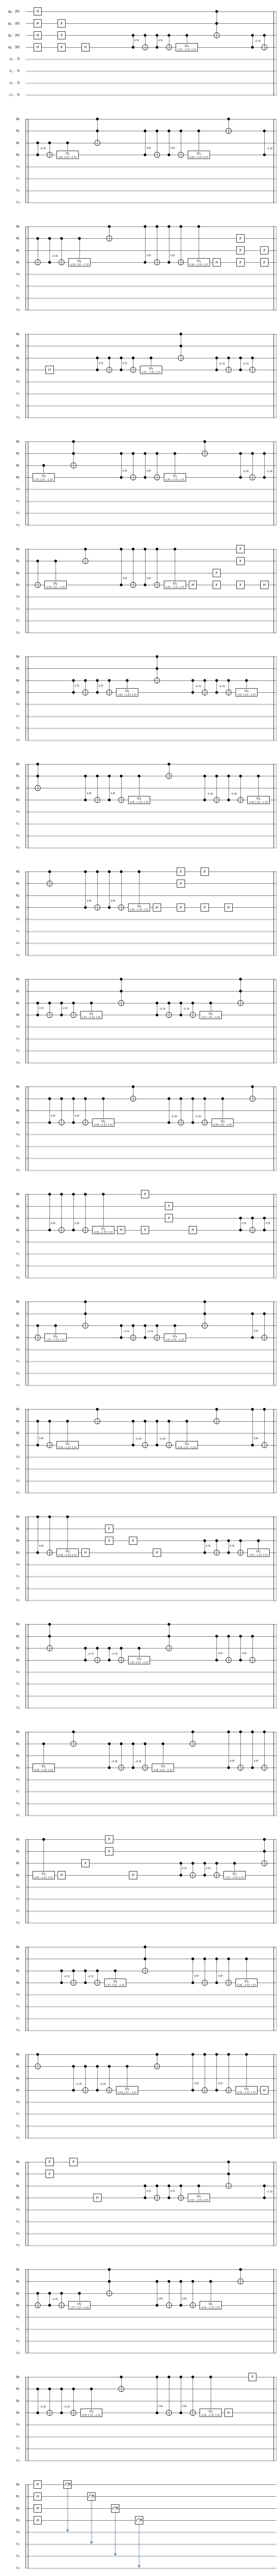

In [16]:
def limite_prec(n):
    """Test for the precision of cnx"""
    q = QuantumRegister(n, 'q')
    circ = QuantumCircuit(q)
    controls = [q[i] for i in range(n-2,-1,-1)]
    print(controls)
    circ.x(q)
    circ.barrier(q)
    cnx(circ, q, controls, q[n-1])
    circ_m = measure(circ, q, [i for i in range(n)])
    return circ_m

def oracle(circ, reg, n, bi):
    """Oracle for the binary bi"""
    circ.barrier(reg)
    for i in bi:
        circ.x(reg[i])
    circ.barrier(reg)
    circ.h(reg[n-1])
    cnx(circ, reg, [reg[i] for i in range(n-2,-1,-1)], reg[n-1])
    circ.h(reg[n-1])
    circ.barrier(reg)
    for i in bi:
        circ.x(reg[i])

def bina(n):
    """List of all binary"""
    if n ==1:
        return [[0],[]]
    b = bina(n-1)
    return [ [n-1]+i for i in b ]+b

def boite_noire(circ, q, n):
    """The secret function for Deutsch Josza"""
    secret = bina(n)#[ [0,1,2], [0,1], [0,2], [0], [1,2], [1], [2], [] ]
    r.shuffle(secret)
    if r.random()<0.5:
        return 0
    else:
        for i in range(2**(n-1)):
            print(secret[i])
            oracle(circ, q, n, secret[i])
        return 1

def oracle_BV(circ, q, n, nbr):
    binary = bina(n)
    for i in range(2**n):
        if bin(i&nbr).count('1')%2:
            oracle(circ, q, n, binary[i])
    return 1
    
def deutsh(n):
    """Deutsch-Josza algorithm for n qbits, the function is secret and randomly generated"""
    q = QuantumRegister(n, 'q')
    circ = QuantumCircuit(q)
    
    circ.h(q)
    print(boite_noire(circ, q,n))
    circ.barrier(q)
    circ.h(q)
    
    circ_m = measure(circ, q, [i for i in range(n)])
    return circ_m

def better_grover(n):
    """Return a circuit with a grover algorithm on n qbits, with secret search"""
    q = QuantumRegister(n, 'q')
    circ = QuantumCircuit(q)
    controls = [q[i] for i in range(n-2,-1,-1)]
    secret = bina(n)#[ [0,1,2], [0,1], [0,2], [0], [1,2], [1], [2], [] ]
    r.shuffle(secret)
    search = secret[0]
    print(search)
    circ.h(q)
    
    stop = 1*(n<3) + int(np.sqrt(n)+1)*(n>=3)
    
    for _ in range(stop):
        oracle(circ, q, n, search)
        circ.barrier(q)
        circ.h(q)
        circ.x(q)
        circ.h(q[n-1])
        cnx(circ, q, controls, q[n-1])
        circ.h(q[n-1])
        circ.barrier(q)
        circ.x(q)
        circ.h(q)

    circ_m = measure(circ, q, [i for i in range(n)])
    return circ_m

def ccxtest(n):
    """Truth table for cnx"""
    b = bina(n)
    for bi in b:
        print(bi)
        q = QuantumRegister(n, 'q')
        circ = QuantumCircuit(q)
        for i in bi:
            circ.x(q[i])
        cnx(circ, q, [q[i] for i in range(n-2,-1,-1)], q[n-1])
        circ.barrier(q)
        launch2(circ)
        
        circ_m = measure(circ, q, [i  for i in range(n)])
    return circ_m

def crootnxtest(n):
    """Truth table for crootnx"""
    b = bina(n)
    for bi in b:
        print(bi)
        q = QuantumRegister(n, 'q')
        circ = QuantumCircuit(q)
        for i in bi:
            circ.x(q[i])
        for _ in range(2**(n)):
            crootnx(circ, q, q[0], q[n-1], 2**n, False)
        circ.barrier(q)
        launch2(circ)
        
        circ_m = measure(circ, q, [i  for i in range(n)])
    
    return circ_m

def oracletest(n):
    """Test All Oracles"""
    b = bina(n)
    for bi in b:
        print(bi)
        q = QuantumRegister(n, 'q')
        circ = QuantumCircuit(q)
        circ.h(q)
        #for i in bi:
        #    circ.x(q[i])
        oracle(circ, q, n, bi)
        circ.barrier(q)
        launch2(circ)
        circ_m = measure(circ, q, [i  for i in range(n)])
    
    return circ_m

def bernsteinv(n, nbr):
    q = QuantumRegister(n, 'q')
    circ = QuantumCircuit(q)
    circ.h(q)
    print(oracle_BV(circ, q,n, nbr))
    circ.barrier(q)
    circ.h(q)
    
    circ_m = measure(circ, q, [i for i in range(n)])
    return circ_m

#Tests
circ_m = bernsteinv(4,5)
launch2(circ_m)
o = launch(2048,circ_m)
circ_m.draw(output='mpl', plot_barriers = False)

In [17]:

def cnx_o_paquet(c, r, cont, target, losts):
    """Adds a len(cont)-qbits-Control(X) gate to c, on r, controlled by the List cont at qbit target, losing one qbit in the process"""
    #c.barrier(r)
    #print(len(cont), len(losts))
    if len(cont) == 1:
        c.cx(cont[0], target)
    elif len(cont) == 2:
        c.ccx(cont[0],cont[1],target)
    elif len(cont) == 3:# and len(losts) == 1:
        c.ccx(cont[2], cont[1], losts[0])
        c.ccx(cont[0], losts[0], target)
        c.ccx(cont[2], cont[1], losts[0])
        c.ccx(cont[0], losts[0], target)
    #elif len(cont) == 4 and len(losts) == 1:
    #    cnx_o(c, r, cont, target, losts[0])
    #elif len(cont) == 5:
    #    cnx_o(c, r, cont, target, losts[0])
    else:
        m = len(cont)
        #print(m)
        #c.barrier(r)
        c.ccx(cont[0],losts[0], target)
        #c.barrier(r)
        #c.h(r)
        
        for i in range(1,m-2):
            c.ccx(cont[i], losts[i], losts[i-1])
        #c.barrier(r)
        c.ccx(cont[-1], cont[-2], losts[m-3])
        #c.barrier(r)
        for i in range(m-3,0,-1):
            c.ccx(cont[i], losts[i], losts[i-1])
        #c.barrier(r)
        c.ccx(cont[0],losts[0], target)
        #c.barrier(r)
        for i in range(1,m-2):
            c.ccx(cont[i], losts[i], losts[i-1])
        #c.barrier(r)
        c.ccx(cont[-1], cont[-2], losts[m-3])
        #c.barrier(r)
        for i in range(m-3,0,-1):
            c.ccx(cont[i], losts[i], losts[i-1])
    return 1

def cnx_o(c, r, cont, target, lost):
    """Adds a len(cont)-qbits-Control(X) gate to c, on r, controlled by the List cont at qbit target, losing one qbit in the process"""
    c.barrier(r)
    if len(cont) == 1:
        c.cx(cont[0], target)
    elif len(cont) == 2:
        c.ccx(cont[0],cont[1],target)
    elif len(cont) == 3:
        c.ccx(cont[2], cont[1], lost)
        c.ccx(cont[0], lost, target)
        c.ccx(cont[2], cont[1], lost)
        c.ccx(cont[0], lost, target)
    else:
        m = int(np.ceil(len(cont)/2+1))
        m1 = len(cont)-m
        #print(m, len(cont)+2, len(cont), m1)
        #A more efficient way to do this would be defining a new circuit
        #and just multiply it istead of doing the same thing twice
        cnx_o_paquet(c, r, cont[m1:], lost, [target]+cont[:m1])
        cnx_o_paquet(c, r, [lost]+cont[:m1], target, cont[m1:])
        cnx_o_paquet(c, r, cont[m1:], lost, [target]+cont[:m1])
        cnx_o_paquet(c, r, [lost]+cont[:m1], target, cont[m1:])
    return 1  

def ccx_otest(n):
    """Truth table for cnx"""
    b = [bina(n+1)[0]]
    #b = bina(n+1)
    for bi in b:
        print(bi)
        q = QuantumRegister(n+1, 'q')
        circ = QuantumCircuit(q)
        for i in bi:
            circ.x(q[i])
        cnx_o(circ, q, [q[i] for i in range(n-2,-1,-1)], q[n], q[n-1])
        #circ.mct([q[i] for i in range(n-2,-1,-1)], q[n], q[n-1])
        circ.barrier(q)
        launch2(circ)
        
        circ_m = measure(circ, q, [i  for i in range(n+1)])
    return circ_m

circ_m = ccx_otest(13)
#circ_m.draw(output='mpl', plot_barriers = False)


[13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]


1
[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.-0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j]
{'0101': 2048}


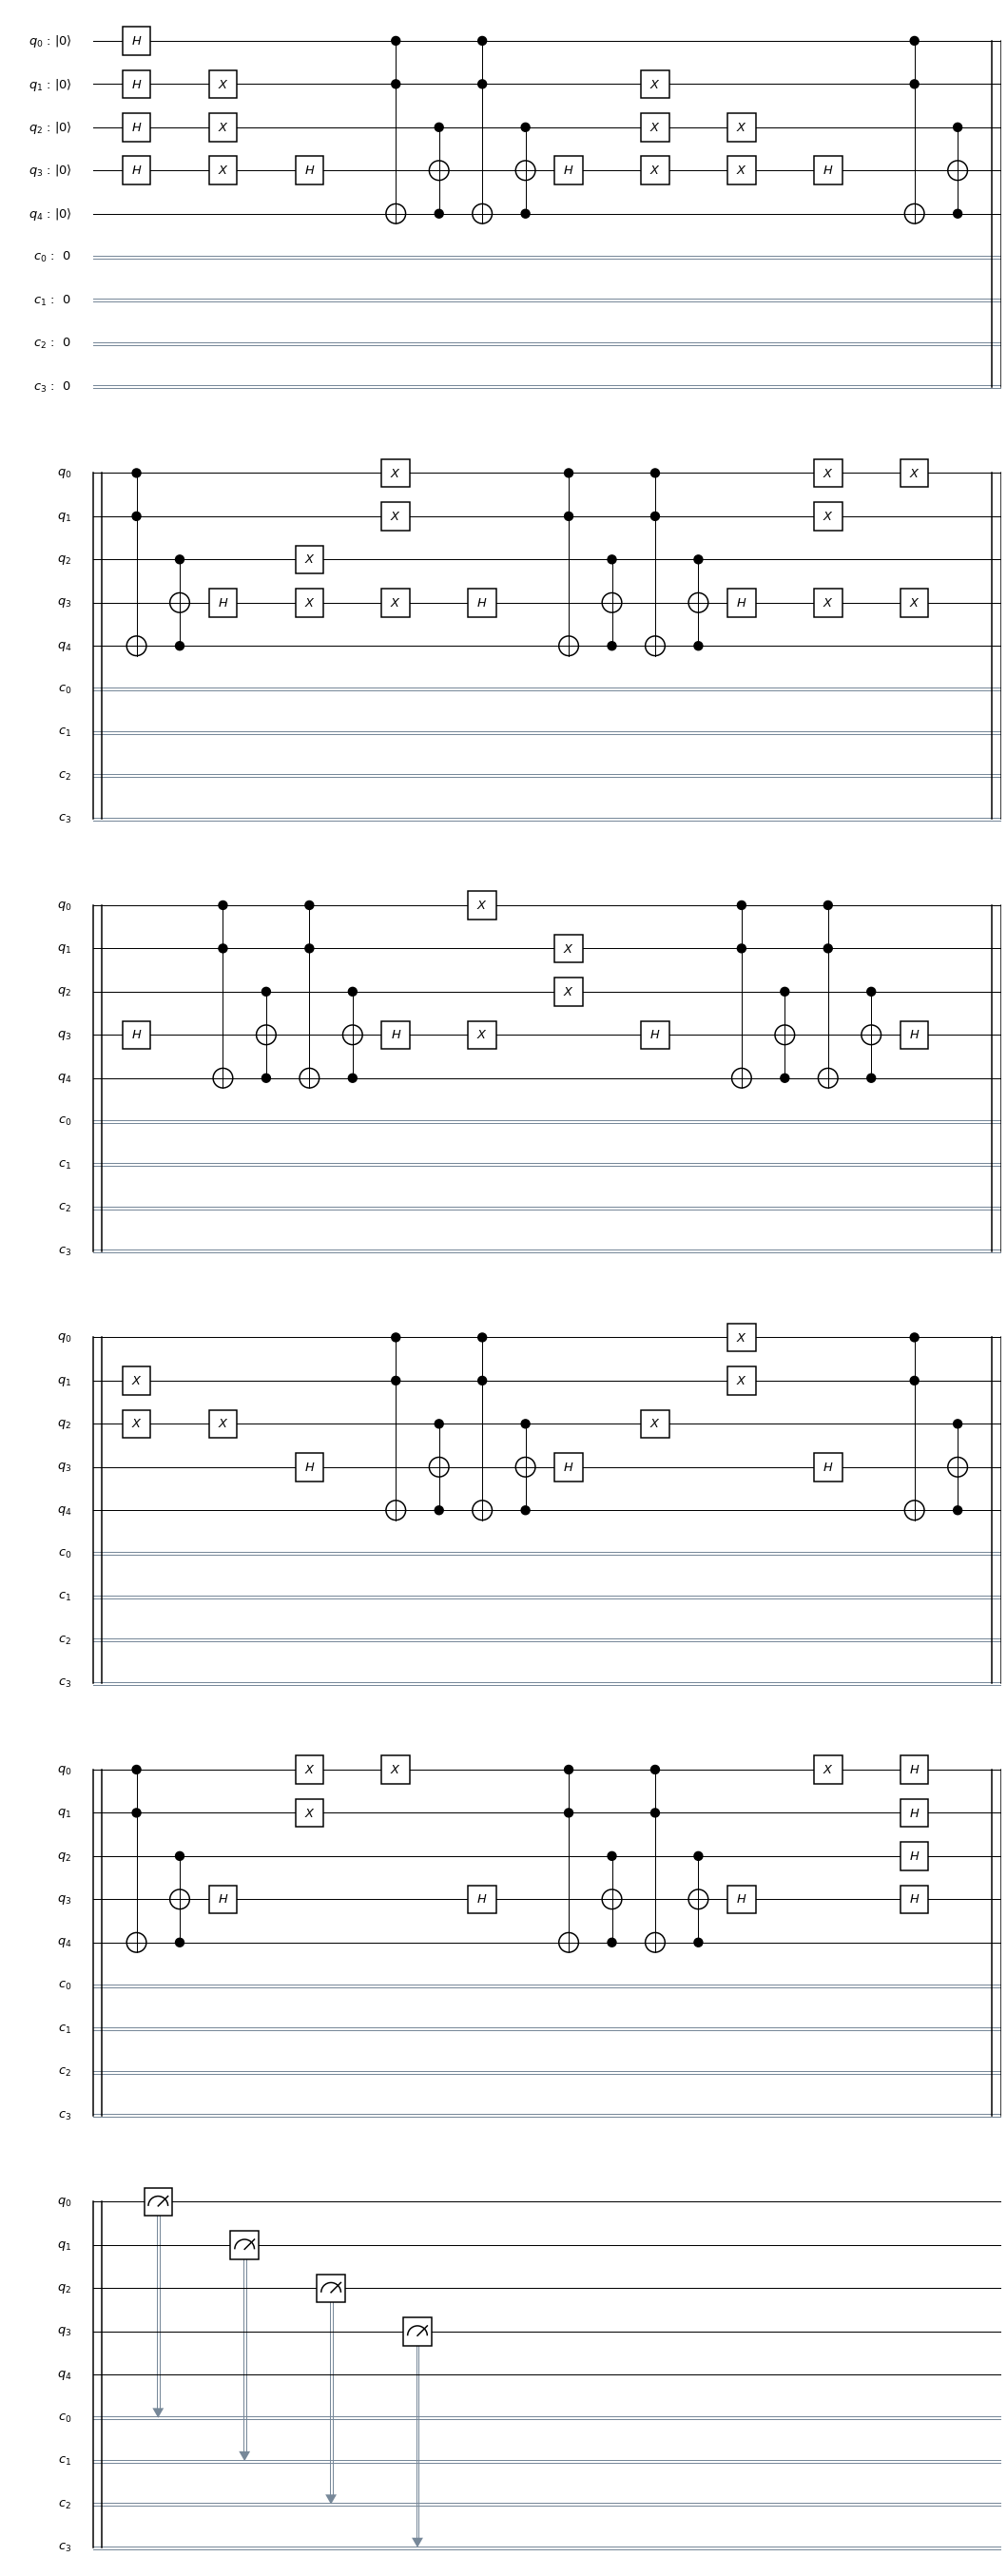

In [18]:
def oracle_o(circ, reg, n, bi):
    """Oracle for the binary bi"""
    circ.barrier(reg)
    for i in bi:
        circ.x(reg[i])
    circ.barrier(reg)
    circ.h(reg[n-1])
    cnx_o(circ, reg, [reg[i] for i in range(n-2,-1,-1)], reg[n-1], reg[n])
    circ.h(reg[n-1])
    circ.barrier(reg)
    for i in bi:
        circ.x(reg[i])

def oracle_BV_o(circ, q, n, nbr):
    binary = bina(n)
    for i in range(2**n):
        if bin(i&nbr).count('1')%2:
            oracle_o(circ, q, n, binary[i])
    return 1

def bernsteinv_o(n, nbr):
    q = QuantumRegister(n+1, 'q')
    circ = QuantumCircuit(q)
    for i in range(n):
        circ.h(q[i])
    print(oracle_BV_o(circ, q,n, nbr))
    circ.barrier(q)
    for i in range(n):
        circ.h(q[i])
    #circ.h(q)
    
    circ_m = measure(circ, q, [i for i in range(n)])
    return circ_m

#Tests
circ_m = bernsteinv_o(4,5)
launch2(circ_m)
o = launch(2048,circ_m)
circ_m.draw(output='mpl', plot_barriers = False)

In [19]:
def powmod(a,p,n):
    """A**p%n"""
    res = 1
    for _ in range(p):
        res = (res*a)%n
    return res

def inversemod(a, n):
    b=n
    a, sa = abs(a), -1 if a<0 else 1
    b, sb = abs(b), -1 if b<0 else 1
    vv, uu, v, u = 1, 0, 0, 1 
    e=1
    q, rr = divmod(a, b)
    while rr:
        a, b = b, rr
        vv, v = q*vv+v, vv
        uu, u = q*uu+u, uu
        e = -e
        q, rr = divmod(a, b)
    res = -sa*e*uu
    return res if res>0 else n+res

def measure_direct(circ, reg, targ):
    """Returns circ with measures added on reg on each qbit index specified in targ"""
    c = ClassicalRegister(len(targ), 'c')
    meas = QuantumCircuit(reg, c)
    for i in range(len(targ)):
        meas.measure(targ[i],c[i])
    return circ+meas

def MAJ(circ, q, c, b, a):
    circ.barrier(q)
    circ.cx(a, b)
    circ.cx(a, c)
    circ.ccx(b, c, a)

def JAM(circ, q, c, b, a):
    circ.barrier(q)
    circ.ccx(b, c, a)
    circ.cx(a, c)
    circ.cx(a, b)

def UMA(circ, q, c, b, a):
    circ.barrier(q)
    circ.ccx(b, c, a)
    circ.cx(a, c)
    circ.cx(c, b)

def AMU(circ, q, c, b, a):
    circ.barrier(q)
    circ.cx(c, b)
    circ.cx(a, c)
    circ.ccx(b, c, a)

def add(circ, q, A, B, lost, last):
    """A and B are lists of the bits of a and b to be added, lost is ancilla"""
    MAJ(circ, q, lost, B[0], A[0])
    for i in range(1,len(A)):
        MAJ(circ, q, A[i-1], B[i], A[i])
    circ.cx(A[-1],last)
    for i in range(len(A)-1, 0,-1):
        UMA(circ, q, A[i-1], B[i], A[i])
    UMA(circ, q, lost, B[0], A[0])
    #now a=a and b = b+a

def addmod(circ, q, A, B, lost, last, N, lost2, binn):
    add(circ, q, A, B, lost, last)
    sub(circ, q, N, B, lost, last)
    circ.x(last)
    circ.cx(last, lost2)
    circ.x(last)
    #control swap N to 0
    for i in range(len(binn)):
        if binn[i]:
            circ.cx(lost2, N[i])
    add(circ, q, N, B, lost, last)
    #control swap 0 to N
    for i in range(len(binn)):
        if binn[i]:
            circ.cx(lost2, N[i])
    sub(circ, q, A, B, lost, last)
    circ.cx(last, lost2)
    add(circ, q, A, B, lost, last)

def sub(circ, q, A, B, lost, last):
    AMU(circ, q, lost, B[0], A[0])
    for i in range(1,len(A)):
        AMU(circ, q, A[i-1], B[i], A[i])
    circ.cx(A[-1],last)
    for i in range(len(A)-1, 0,-1):
        JAM(circ, q, A[i-1], B[i], A[i])
    JAM(circ, q, lost, B[0], A[0])

def submod(circ, q, A, B, lost, last, N, lost2, binn):
    sub(circ, q, A, B, lost, last)
    circ.cx(last, lost2)
    add(circ, q, A, B, lost, last)
    for i in range(len(binn)-1, -1, -1):
        if binn[i]:
            circ.cx(lost2, N[i])
    sub(circ, q, N, B, lost, last)
    for i in range(len(binn)-1, -1, -1):
        if binn[i]:
            circ.cx(lost2, N[i])
    circ.x(last)
    circ.cx(last, lost2)
    circ.x(last)
    add(circ, q, N, B, lost, last)
    sub(circ, q, A, B, lost, last)
    
def cmultmod(circ, q, control, X, a, A, Y, n, N, binn, lost, lost2):
    """control the control qbit, B the list of qbits of b, bina the bitlist of a,
    A the list of qbits (at zero) with enough place to put a, Y the res register,
    N the modulo register, binn its bitlist and lost and lost2 two ancillas"""
    binapow = [ [int(x) for x in bin((powmod(2,i,n)*a)%n)[2:]] for i in range(len(X)) ]
    for i in range(len(binapow)):
        binapow[i].reverse()
    #for i in range(len(X)):
    #    print((powmod(2,i,n)*a)%n,a,i)
    #    print(binapow)
    for i in range(len(X)):
        for j in range(len(binapow[i])):
            if binapow[i][j]:
                circ.ccx(control, X[i], A[j])
        addmod(circ, q, A, Y, lost, Y[-1], N, lost2, binn)#Y may be too long?
        for j in range(len(binapow[i])):
            if binapow[i][j]:
                circ.ccx(control, X[i], A[j])
    circ.x(control)
    for i in range(len(X)):
        circ.ccx(control,X[i],Y[i])
    circ.x(control)
    #A=0->0;X->X,Y=0->X if not control else x*a, N->N

def cdivmod(circ, q, control, X, a, A, Y, n, N, binn, lost, lost2):
    binapow = [ [int(x) for x in bin((powmod(2,i,n)*a)%n)[2:]] for i in range(len(X)) ]
    for i in range(len(binapow)):
        binapow[i].reverse()
    circ.x(control)
    for i in range(len(X)-1, -1, -1):
        circ.ccx(control,X[i],Y[i])
    circ.x(control)
    for i in range(len(X)-1, -1, -1):
        for j in range(len(binapow[i])-1, -1, -1):
            if binapow[i][j]:
                circ.ccx(control, X[i], A[j])
        submod(circ, q, A, Y, lost, Y[-1], N, lost2, binn)#Y may be too long?
        for j in range(len(binapow[i])-1, -1, -1):
            if binapow[i][j]:
                circ.ccx(control, X[i], A[j])

def expmod(circ, q, X, a, A, APOW, Y, n, N, binn, lost, lost2):
    """A and B are lists of the bits of a and b to be a**b%n, lost is ancilla"""
    #for _ in range()
    #a**2**i%n=powmod(a,2**i,n) or powmod(inversemod(a),2**i,n)
    circ.x(APOW[0])
    temp = []
    for i in range(len(X)):
        control = X[i]
        cmultmod(circ, q, control, APOW, powmod(a,2**i,n), A, Y, n, N, binn, lost, lost2)
        temp = APOW.copy()
        APOW = Y[:-1]
        Y = temp+[Y[-1]]
        #print(control, "|",APOW,Y)
        cdivmod(circ, q, control, APOW, powmod(inversemod(a,n),2**i,n), A, Y, n, N, binn, lost, lost2)
    return 1

def QFTn(circ, q, X):
    lamb = [2*np.pi/(2**m) for m in range(2,len(X)+1)]
    X.reverse()
    #print(len(lamb))
    for i in range(len(X)):
        circ.h(X[i])
        for j in range(len(lamb)-i):
            #print(i,j)
            circ.cu1(lamb[j],X[1+j+i],X[i])
    X.reverse()
    return 1

def shor_quant(A,N, maxQ):
    binn = [int(x) for x in bin(N)[2:]]
    binn.reverse()
    bits_N = len(binn)
    bits_X = maxQ-4*(bits_N+1)+(maxQ-4*(bits_N+1))%2
    if bits_X<2*bits_N:
        print("Not enough qbits")
        return 0
    #Dans l'ordre:X(m)|Y(n+1)|N(n)|A(n)|APOW(n)|lost|lost2
    #nombre total de qbits: 7*n+3+1*(3*n%2)
    
    nX = bits_X #q[nX] debut de Y
    nXY = nX+bits_N+1 #q[nXY] debut de N
    nXYN = nXY+bits_N #q[nXYN] debut de A
    nXYNA = nXYN+bits_N #q[nXYNA] debut de APOW
    n = nXYNA+bits_N #Total de qbit chargés

    q = QuantumRegister(n+2, 'q')#+lost+lost2=+2
    circ = QuantumCircuit(q)
    
    RegX = [q[i] for i in range(bits_X)]
    RegY = [q[i+nX] for i in range(nXY-nX)]
    RegN = [q[i+nXY] for i in range(nXYN-nXY)]
    RegA = [q[i+nXYN] for i in range(nXYNA-nXYN)]
    RegAPOW = [q[i+nXYNA] for i in range(n-nXYNA)]
    
    #circ.h(RegX)#Unif on X
    for r in RegX:
        circ.h(r)
    for r in [RegN[i] for i in range(bits_N) if binn[i] ]:
        circ.x(r)#Set N
    
    expmod(circ, q,# X, a, A, APOW, Y, n, N, binn, lost, lost2)
           RegX,
           A,
           RegA,
           RegAPOW,
           RegY,
           N,
           RegN,
           binn,
           q[n],
           q[n+1])
    
    RegY = RegAPOW#Comme bits_X est pair, le resultat A**x%n est dans RegAPOW
    for r in [RegN[i] for i in range(bits_N) if binn[i] ]:
        circ.x(r)#Reset N
    
    QFTn(circ,q,RegX)#Fourier transform de X
    circ_m = measure_direct(circ, q, RegX+RegY)
    
    return circ_m

def periodfinder(A,n):
    qperiodfinder(A,n)
    res = 1
    fun = A
    while fun != 1:
        fun = (fun*A)%n
        res += 1
    return res

def qperiodfinder(A,n):
    maxQ = 26
    circ_m = shor_quant(A,n,maxQ)
    if circ_m is 0:
        return 0
    backend_sim = IBMQ.get_backend('ibmq_qasm_simulator', hub=None)#BasicAer.get_backend('qasm_simulator')
    job_sim = execute(circ_m, backend_sim, shots=1, max_credits = 3)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(circ_m)
    print(counts, type(counts))
    bits_N = len(bin(n))-2
    bits_X = maxQ-4*(bits_N+1)+(maxQ-4*(bits_N+1))%2
    for key in counts:
        print(key)
        print(type(key))
        S = int('0b'+key[bits_N:])
        N = 2**bits_X
        print("S:",S,"N:",N)
    

def shor(n):
    print("Starting...")
    A = r.randrange(2,n)
    print("A:",A)
    res = np.gcd(A,n)
    if res !=1:
        print("Lucky find!")
        return (res,n//res)
    #DEBUT PROCEDURE QUANTIQUE
    res = periodfinder(A,n)
    print("Res:",res)
    #fin
    if res%2:
        print("Period not even...")
        return shor(n)
    else:
        L = res//2
        R = powmod(A,L,n)
        if R==1 or R+1==n:
            print("Trivial root...")
            return shor(n)
        P = np.gcd(R-1, n)
        print("Result found!")
        return (P,n//P)

def addition(a,b):
    """mesure b = b+a, a reste a"""
    bina = [int(x) for x in bin(a)[2:]]
    binb = [int(x) for x in bin(b)[2:]]
    while len(bina)>=len(binb):
        binb = [0]+binb
    while len(bina)<len(binb)-1:
        bina = [0]+bina
    bina.reverse()
    binb.reverse()
    n = len(bina)+len(binb)
    na = len(bina)
    q = QuantumRegister(n+1, 'q')
    circ = QuantumCircuit(q)
    for i in range(na):
        if bina[i]:
            circ.x(q[i])
    for i in range(len(binb)):
        if binb[i]:
            circ.x(q[na+i])
    add(circ, q, [q[i] for i in range(len(bina))], [q[i+na] for i in range(len(binb)-1)], q[n], q[na+len(binb)-1])
    circ_m = measure(circ, q, [i for i in range(na,n)])
    return circ_m

def soustraction(a,b):
    """a = a, b = b-a, mesure b-a"""
    bina = [int(x) for x in bin(a)[2:]]
    binb = [int(x) for x in bin(b)[2:]]
    while len(bina)>=len(binb):
        binb = [0]+binb
    while len(bina)<len(binb)-1:
        bina = [0]+bina
    bina.reverse()
    binb.reverse()
    n = len(bina)+len(binb)
    na = len(bina)
    q = QuantumRegister(n+1, 'q')
    circ = QuantumCircuit(q)
    for i in range(na):
        if bina[i]:
            circ.x(q[i])
    for i in range(len(binb)):
        if binb[i]:
            circ.x(q[na+i])
    sub(circ, q, [q[i] for i in range(len(bina))], [q[i+na] for i in range(len(binb)-1)], q[n], q[na+len(binb)-1])
    circ_m = measure(circ, q, [i for i in range(na,n)])
    return circ_m

def addition_mod(a,b,nbr):
    """mesure b = b+a, a reste a"""
    bina = [int(x) for x in bin(a)[2:]]
    binb = [int(x) for x in bin(b)[2:]]
    binn = [int(x) for x in bin(nbr)[2:]]
    print(binn)
    while len(bina)>=len(binb):
        binb = [0]+binb
    while len(bina)<len(binb)-1:
        bina = [0]+bina
    while len(binn)<len(bina):
        binn = [0]+binn
    while len(binn)>len(bina):
        bina = [0]+bina
        binb = [0]+binb
    binn.reverse()
    bina.reverse()
    binb.reverse()
    print(bina, binb, binn)
    n = len(bina)+len(binb)+len(binn)
    na = len(bina)
    nab = len(bina)+len(binb)
    q = QuantumRegister(n+2, 'q')
    circ = QuantumCircuit(q)
    for i in range(na):
        if bina[i]:
            circ.x(q[i])
    for i in range(len(binb)):
        if binb[i]:
            circ.x(q[na+i])
    for i in range(len(binn)):
        if binn[i]:
            circ.x(q[nab+i])
    addmod(circ, q,# A, B, lost, last, N, lost2, binn):
           [q[i] for i in range(len(bina))],
           [q[i+na] for i in range(len(binb)-1)],
           q[n],
           q[na+len(binb)-1],
           [q[i+nab] for i in range(len(binn))],
           q[n+1],
           binn)
    circ_m = measure(circ, q, [i for i in range(na,nab)])
    return circ_m

def mult_mod(a,b,nbr,control):
    """mesure b = b*a, a reste a, if control else b = a"""
    bina = [int(x) for x in bin(a)[2:]]
    #binb = [int(x) for x in bin(b)[2:]]
    binn = [int(x) for x in bin(nbr)[2:]]
    while len(binn)<len(bina):
        binn = [0]+binn
    #print(bina, binn)
    binn.reverse()
    bina.reverse()
    n = len(bina)+len(binn)*3+1
    na = len(bina)
    nan = len(bina)+len(binn)#debut de Y
    nany = len(bina)+2*len(binn)+1#debut de "A" (ici c'est b)
    q = QuantumRegister(n+2+1, 'q')#+lost+lost2+control
    circ = QuantumCircuit(q)
    for i in range(na):
        if bina[i]:
            circ.x(q[i])
    for i in range(len(binn)):
        if binn[i]:
            circ.x(q[na+i])
    if control:
        circ.x(q[n+2])
    cmultmod(circ, q,#control, X, a, A, Y, n, N, binn, lost, lost2
           q[n+2],
           [q[i] for i in range(len(bina))],
           b,
           [q[i+nany] for i in range(len(binn))],
           [q[i+nan] for i in range(len(binn)+1)],
           nbr,
           [q[i+na] for i in range(len(binn))],
           binn,
           q[n],
           q[n+1])
    circ_m = measure(circ, q, [i for i in range(nan,nany)])
    return circ_m

def exp_mod(a,b,nbr):
    """mesure b = b*a, a reste a, if control else b = a"""
    bina = [int(x) for x in bin(a)[2:]]
    #binb = [int(x) for x in bin(b)[2:]]
    binn = [int(x) for x in bin(nbr)[2:]]
    #while len(binn)<len(bina):
    #    binn = [0]+binn
    #print(bina, binn)
    binn.reverse()
    bina.reverse()
    n = len(bina)+len(binn)*4+1
    na = len(bina)
    nan = len(bina)+len(binn)#debut de Y
    nany = len(bina)+2*len(binn)+1#debut de "A" (ici c'est b)
    nanya = len(bina)+3*len(binn)+1#debut de "APOW" (ce qui doit etre mesuré)
    q = QuantumRegister(n+2, 'q')#+lost+lost2
    circ = QuantumCircuit(q)
    for i in range(na):
        if bina[i]:
            circ.x(q[i])
    for i in range(len(binn)):
        if binn[i]:
            circ.x(q[na+i])
    expmod(circ, q,# X, a, A, APOW, Y, n, N, binn, lost, lost2)
           [q[i] for i in range(len(bina))],
           b,
           [q[i+nany] for i in range(len(binn))],
           [q[i+nanya] for i in range(len(binn))],
           [q[i+nan] for i in range(len(binn)+1)],
           nbr,
           [q[i+na] for i in range(len(binn))],
           binn,
           q[n],
           q[n+1])
    if len(bina)%2:
        circ_m = measure(circ, q, [i for i in range(nan,nany)])
    else:
        circ_m = measure(circ, q, [i for i in range(nanya,n)])
    #circ_m = measure(circ, q, [i for i in range(n)])
    return circ_m

def test_QFTn(n):
    q = QuantumRegister(n, 'q')#+lost+lost2
    circ = QuantumCircuit(q)
    QFTn(circ, q, [q[i] for i in range(n)])
    return circ

#circ_m = test_QFTn(4)
#print(shor(326327279*876896988893))
#print(shor(2281*2741))
#circ_m = exp_mod(3,3,5)
#print("Circuit build! Simulation...")
#launch2(circ_m)
#o = launch(1,circ_m)
#circ_m.draw(output='mpl', plot_barriers = False)
#print(shor(90359*747587))

In [104]:
#a = [0,1]
#b = [2,3,4,5]
temp = []
temp = a
a = b[:-1]
b = temp+[b[-1] ]
print(a)
print(b)

[0, 1]
[2, 3, 4, 5]


In [38]:
print(shor(6))

Starting...
A: 5
{'1010000000001': 1} <class 'dict'>
1010000000001
<class 'str'>


ValueError: invalid literal for int() with base 10: '0b0000000001'